 ## **[Nhóm 11] Nhận diện biểu cảm gương mặt**

 ### **Nhập các thư viện**.

Nhập các thư viện cần thiết để xây dựng và huấn luyện một mạng nơ-ron tích chập (CNN) để nhận diện cảm xúc trên khuôn mặt.

- `os`: Cung cấp các hàm để tương tác với hệ điều hành, hữu ích cho các thao tác với tệp.
- `cv2`: Thư viện OpenCV cho các tác vụ thị giác máy tính, được sử dụng ở đây để xử lý hình ảnh.
-`numpy`: Thư viện tính toán số học, được sử dụng cho các thao tác mảng.
- `tensorflow`: Thư viện TensorFlow cho học sâu.
- `train_test_split` từ sklearn.model_selection: Chia dữ liệu thành các tập huấn luyện và kiểm tra.
- `ImageDataGenerator` từ tensorflow.keras.preprocessing.image: Tạo ra các lô dữ liệu tăng cường.
- `LabelEncoder` từ sklearn.preprocessing: Mã hóa các nhãn mục tiêu với các giá trị giữa 0 và n_classes-1.
- `to_categorical` từ keras.utils: Chuyển đổi vector lớp (số nguyên) thành ma trận lớp nhị phân.
- `Sequential` từ keras.models: Ngăn xếp tuyến tính của các lớp để xây dựng mô hình học sâu.
- `Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten` từ keras.layers: Các loại lớp khác nhau được sử dụng trong kiến trúc CNN.
- `Optimizers` (Adam, RMSprop, SGD) từ keras.optimizers: Các thuật toán được sử dụng để cập nhật trọng số mô hình trong quá trình huấn luyện.
- `plt` từ matplotlib.pyplot: Thư viện để tạo các hình ảnh minh họa, được sử dụng ở đây để vẽ các đường cong huấn luyện/kiểm tra.
- Callbacks (ModelCheckpoint, EarlyStopping, ReduceLROnPlateau) từ keras.callbacks: Các hàm được gọi trong quá trình huấn luyện tại một số điểm nhất định để cải thiện hiệu suất mô hình hoặc xử lý các gián đoạn huấn luyện.

In [1]:
import os
import cv2
import numpy as np
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Biến `data_dir` chỉ định thư mục nơi bộ dữ liệu được đặt. Trong trường hợp này, nó được đặt là "images/train". Thư mục này có khả năng chứa các thư mục con với hình ảnh được tổ chức thành các lớp hoặc danh mục khác nhau, chẳng hạn như các biểu cảm khuôn mặt khác nhau. Các hình ảnh trong các thư mục con này sẽ được sử dụng để huấn luyện mô hình nhận diện cảm xúc trên khuôn mặt.

In [2]:
# Dataset Directory
data_dir = "images/train"


Biến `sub_folders` được gán danh sách các thư mục con trong thư mục bộ dữ liệu data_dir. Các thư mục con này đại diện cho các lớp hoặc danh mục dữ liệu khác nhau, chẳng hạn như các biểu cảm khuôn mặt khác nhau. Mỗi thư mục con chứa các hình ảnh tương ứng với lớp tương ứng của nó.

In [3]:
# Classes
sub_folders = os.listdir(data_dir)

Hai danh sách, `images` và `labels`, được khai báo để lưu trữ dữ liệu hình ảnh và các nhãn tương ứng. Các danh sách này sẽ được điền vào trong quá trình tải dữ liệu, khi các hình ảnh từ mỗi lớp được đọc và thêm vào danh sách `images`, trong khi các nhãn tương ứng của chúng được thêm vào danh sách `labels`.

In [4]:
# Declaring the lists for images and labels
images = []
labels = []

### **Tiền xử lý dữ liệu**

Đoạn mã này lặp qua từng thư mục con trong danh sách `sub_folders`, đại diện cho các lớp hoặc nhãn khác nhau. Nó sau đó truy cập các hình ảnh trong mỗi thư mục con, đọc chúng bằng OpenCV và thêm vào danh sách `images`. Ngoài ra, nó cũng thêm nhãn tương ứng (tên của thư mục con) vào danh sách `labels`.

In [5]:
# Accessing the labels
for sub_folder in sub_folders:
    label = sub_folder

    # Constructing the path to the current sub-folder
    path = os.path.join(data_dir, sub_folder)

    # Listing all images in the current sub-folder
    sub_folder_images = os.listdir(path)

    # Accessing the Images
    for image_name in sub_folder_images:
        # Constructing the path to the current image
        image_path = os.path.join(path, image_name)
        # Loading the image using OpenCV
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        # Appending the image to the list of images
        images.append(img)
        # Appending the label corresponding to the current sub-folder to the list of labels
        labels.append(label)

Danh sách các hình ảnh và nhãn được chuyển đổi thành các mảng NumPy bằng cách sử dụng hàm `np.array()`. Việc chuyển đổi này là cần thiết cho quá trình xử lý tiếp theo và để tương thích với các khung học sâu như TensorFlow và Keras.

In [6]:
# Converting the lists of images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)
print(len(images))

28821


Bộ dữ liệu được chia thành các tập huấn luyện, validation và kiểm tra bằng cách sử dụng hàm `train_test_split` từ scikit-learn.

- `X_train`, `y_train`: Hình ảnh và nhãn của tập huấn luyện.
- `X_val`, `y_val`: Hình ảnh và nhãn của tập validation.
- `X_test`, `y_tes`: Hình ảnh và nhãn của tập kiểm tra.

Bộ dữ liệu được chia với kích thước tập kiểm tra là 20% và kích thước tập validation là 10% của bộ dữ liệu gốc. Tham số `random_state` đảm bảo tính tái tạo của việc chia tập.

In [7]:
# Splitting Dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)

Hàm tiền xử lý được định nghĩa để tiền xử lý các hình ảnh đầu vào trước khi đưa chúng vào mô hình mạng nơ-ron.

- Chuẩn hóa các giá trị pixel bằng cách chia mỗi pixel cho 255.0, điều này đưa các giá trị pixel về phạm vi [0, 1].
- Thay đổi kích thước của hình ảnh thành kích thước cố định là 48x48 pixel bằng cách sử dụng hàm resize của OpenCV.
- Định hình mảng hình ảnh để phù hợp với hình dạng đầu vào được mong đợi bởi mô hình mạng nơ-ron. Hình dạng này là `(batch_size, chiều cao, chiều rộng, kênh)`, trong đó `batch_size` được đặt là -1 để chỉ định kích thước batch size và `channels` được đặt là 1 cho các hình ảnh xám.


In [8]:
# Preprocess the image
def preprocessing(img):
    img = img / 255.0
    img = cv2.resize(img, (48, 48))
    return img.reshape(-1, 48, 48, 1)  # Reshape to match input shape

Đoạn mã áp dụng hàm `preprocessing` cho mỗi hình ảnh trong các tập huấn luyện, validation và kiểm tra bằng cách sử dụng hàm map, sau đó chuyển đổi danh sách kết quả của các hình ảnh đã tiền xử lý thành các mảng NumPy.

- `map(preprocessing, X_train)`: Áp dụng hàm `preprocessing` cho mỗi hình ảnh trong `X_train`.
- `list(map(...))`: Chuyển đổi đối tượng map thành một danh sách.
- `np.array(...)`: Chuyển đổi danh sách các hình ảnh đã tiền xử lý thành một mảng NumPy.

In [9]:
# Apply preprocessing to training, validation, and test sets
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

Đoạn mã này điều chỉnh hình dạng của các mảng dữ liệu đầu vào để loại bỏ một chiều không cần thiết. Vì hình dạng đầu vào mà model network mong đợi là `(batch_size, height, width, channels)`, trong đó `batch_size` đại diện cho số lượng mẫu trong mỗi lô, chiều không cần thiết sẽ được loại bỏ để đảm bảo tính tương thích với kiến trúc của mô hình.

- `reshape(-1, 48, 48, 1)`: Điều chỉnh hình dạng của các mảng dữ liệu đầu vào để có hình dạng `(batch_size, 48, 48, 1)`, trong đó -1 chỉ ra rằng kích thước lô được xác định động dựa trên số lượng mẫu.

In [10]:
# Reshape input data to remove unnecessary dimension
X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

Đối tượng `ImageDataGenerator` được khởi tạo với các tham số tăng cường dữ liệu khác nhau để tăng cường các hình ảnh huấn luyện. Tăng cường dữ liệu là một kỹ thuật được sử dụng để tăng kích thước của tập dữ liệu huấn luyện bằng cách áp dụng các biến đổi ngẫu nhiên cho các hình ảnh, giúp cải thiện tính tổng quát và tính đáng tin cậy của mô hình.

- `width_shift_range`: Di chuyển ngẫu nhiên chiều rộng của hình ảnh một phần nhỏ của chiều rộng của nó.
- `height_shift_range`: Di chuyển ngẫu nhiên chiều cao của hình ảnh một phần nhỏ của chiều cao của nó.
- `zoom_range`: Phóng to hoặc thu nhỏ ngẫu nhiên hình ảnh.
- `shear_range`: Áp dụng biến đổi cắt ngẫu nhiên cho hình ảnh.
- `rotation_range`: Xoay ngẫu nhiên hình ảnh theo một phạm vi góc nhất định.
Sau đó, phương thức `fit()` được gọi trên đối tượng `ImageDataGenerator` để tính toán các thống kê cần thiết cho việc tăng cường dữ liệu dựa trên dữ liệu huấn luyện.

In [11]:
# Initialize ImageDataGenerator for data augmentation
data_gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    rotation_range=10
)

# Compute necessary statistics for data augmentation
data_gen.fit(X_train)

Đối tượng `LabelEncoder` được khởi tạo để mã hóa các nhãn lớp thành các giá trị số. Điều này cần thiết vì các mô hình máy học thường yêu cầu đầu vào dưới dạng số học. Sau đó, phương thức `fit()` được gọi trên đối tượng LabelEncoder để phù hợp bộ mã hóa với mảng các nhãn lớp, cho phép nó ánh xạ các nhãn lớp thành các giá trị số.

In [12]:
# Encode the class labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)

LabelEncoder()

Các nhãn lớp cho các tập huấn luyện, validation và kiểm tra được mã hóa bằng cách sử dụng phương thức `transform()` của đối tượng `LabelEncoder` được khởi tạo trước đó. Phương thức này ánh xạ các nhãn lớp thành các giá trị số tương ứng của chúng như được xác định trong quá trình phù hợp.

In [13]:
# Encode the class labels for training, validation, and test sets
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

Biến `num_classes` được gán số lượng các lớp duy nhất trong tập dữ liệu, điều này được xác định bằng độ dài của thuộc tính `classes_` của đối tượng `LabelEncoder`.

Sau đó, hàm `to_categorical()` được sử dụng để chuyển đổi các nhãn lớp được mã hóa thành các mảng danh mục được mã hóa một-hot. Việc này là cần thiết cho các nhiệm vụ phân loại đa lớp, trong đó mỗi nhãn lớp được biểu diễn dưới dạng một vector nhị phân với một ở vị trí tương ứng với chỉ số lớp và các giá trị 0 ở nơi khác.

In [14]:
# Get the number of classes
num_classes = len(label_encoder.classes_)

# Convert encoded class labels to one-hot encoded categorical arrays
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_val_categorical = to_categorical(y_val, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

### **Huấn luyện mô hình**
Hàm `build_model` định nghĩa kiến trúc của mạng nơ-ron tích chập (CNN) cho việc nhận dạng biểu cảm khuôn mặt.

- **1st Layer**: Lớp tích chập với 64 bộ lọc kích thước (5, 5), kích hoạt ReLU, và chuẩn hóa lô. Các lớp MaxPooling và Dropout được thêm vào để chính quy hóa.

- **2nd Layer**: Lớp tích chập với 128 bộ lọc kích thước (3, 3), kích hoạt ReLU, và chuẩn hóa lô. Các lớp MaxPooling và Dropout được thêm vào để chính quy hóa.

- **3rd Layer**: Lớp tích chập với 512 bộ lọc kích thước (3, 3), kích hoạt ReLU, và chuẩn hóa lô. Các lớp MaxPooling và Dropout được thêm vào để chính quy hóa.

- **4th Layer**: Lớp tích chập với 512 bộ lọc kích thước (3, 3), kích hoạt ReLU, và chuẩn hóa lô. Các lớp MaxPooling và Dropout được thêm vào để chính quy hóa.

- **Flatten Layer**: Làm phẳng đầu ra từ các lớp tích chập để đưa vào các lớp kết nối đầy đủ.

- **Fully Connected Layer 1**: Lớp Dense với 256 đơn vị và kích hoạt ReLU, tiếp theo là chuẩn hóa lô và dropout để chính quy hóa.

- **Fully Connected Layer 2**: Lớp Dense với 512 đơn vị và kích hoạt ReLU, tiếp theo là chuẩn hóa lô và dropout để chính quy hóa.

- **Output Layer**: Lớp Dense với kích hoạt softmax cho phân loại đa lớp, với số đơn vị bằng số lớp trong tập dữ liệu.

- **Compilation**: Mô hình được biên soạn với tối ưu hóa Adam, hàm mất mát cross-entropy phân loại danh mục và độ chính xác là độ đo.

In [15]:
# Building Model
def build_model():
    model = Sequential()
    # 1st Layer
    model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # 2nd Layer
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # 3rd layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # 4th layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # Flatten Layer
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Fully connected layer 2
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Phương thức `summary()` được gọi trên mô hình đã xây dựng để hiển thị một tóm tắt về kiến ​​trúc của nó, bao gồm các lớp, hình dạng đầu ra và số lượng tham số có thể huấn luyện.

In [16]:
# Build the model
model = build_model()

# Print model summary
print(model.summary())

C:\Users\theng\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 4,348,679 (16.59 MB)

 Trainable params: 4,344,711 (16.57 MB)

 Non-trainable params: 3,968 (15.50 KB)

None


Đối tượng gọi lại `ModelCheckpoint` được khởi tạo để lưu trọng số của mô hình trong quá trình huấn luyện. Nó theo dõi độ chính xác của validation (`val_acc`) và chỉ lưu mô hình tốt nhất (được xác định bởi độ chính xác validation tối đa) vào tệp được chỉ định `"model.h5"`.

In [17]:
# Initialize ModelCheckpoint callback
# checkpoint = ModelCheckpoint("model.h5", monitor="val_acc", verbose=1, save_best_only=True)
# Initialize ModelCheckpoint callback
checkpoint = ModelCheckpoint("model.keras", monitor="val_acc", verbose=1, save_best_only=True)

Đối tượng gọi lại `EarlyStopping` được khởi tạo để theo dõi sự mất mát trên tập validation (`val_loss`). Nó dừng quá trình huấn luyện nếu sự mất mát trên tập validation không cải thiện trong một số epoch nhất định (`patience`), được chỉ định bởi người dùng. Quá trình huấn luyện sẽ được dừng sớm để ngăn chặn hiện tượng quá mức và các trọng số của mô hình hoạt động tốt nhất sẽ được khôi phục (`restore_best_weights=True`).

In [18]:
# Initialize EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

Đối tượng gọi lại `ReduceLROnPlateau` được khởi tạo để điều chỉnh động tốc độ học trong quá trình huấn luyện dựa trên sự mất mát trên tập validation (`val_loss`). Nếu sự mất mát trên tập validation không cải thiện trong một số epoch nhất định (`patience`), tốc độ học sẽ được giảm đi một hệ số được chỉ định bởi người dùng (`factor`). Điều này giúp cải thiện quá trình huấn luyện và ngăn mô hình bị kẹt trong các cực tiểu cục bộ.

In [19]:
# Initialize ReduceLROnPlateau callback
reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
)

Danh sách `callbacks_list` là một danh sách chứa các gọi lại được sử dụng trong quá trình huấn luyện của mô hình. Nó bao gồm các gọi lại `EarlyStopping`, `ModelCheckpoint`, và `ReduceLROnPlateau`, được sử dụng để theo dõi sự mất mát trên tập validation, lưu mô hình tốt nhất, và điều chỉnh tốc độ học, tương ứng.

In [20]:
# List of callbacks
callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

Phương thức `compile()` được gọi trên mô hình để cấu hình quá trình huấn luyện. Nó xác định hàm mất mát, bộ tối ưu hóa và các đánh giá độc lập sẽ được sử dụng trong quá trình huấn luyện.

- **Hàm Mất Mát**: Cross-entropy phân loại danh mục được sử dụng làm hàm mất mát cho các vấn đề phân loại đa lớp.
- **Bộ Tối Ưu Hóa**: Bộ tối ưu hóa Adam được chọn với tốc độ học là 0.001.
- **Đánh Giá**: Độ chính xác được sử dụng làm độc lập để theo dõi hiệu suất của mô hình trong quá trình huấn luyện.

In [21]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

Phương thức `fit()` được gọi trên mô hình để huấn luyện nó trên dữ liệu huấn luyện. Nó nhận các tham số sau:

- `data_gen.flow(X_train, y_train_categorical, batch_size=128)`: Một bộ sinh ra mẫu mà cung cấp các lô dữ liệu huấn luyện được tăng cường. Tăng cường dữ liệu được áp dụng ngay lập tức bằng cách sử dụng đối tượng `ImageDataGenerator` được xác định trước.
- `validation_data=(X_val, y_val_categorical)`: Dữ liệu validation để đánh giá hiệu suất của mô hình sau mỗi epoch.
- `epochs=30`: Số lượng epoch để huấn luyện mô hình.
- `verbose=1`: Xác định chế độ verbose. Ở đây, nó in thanh tiến trình trong quá trình huấn luyện.

In [22]:
# Training the model
history = model.fit(
    data_gen.flow(X_train, y_train_categorical, batch_size=128),
    validation_data=(X_val, y_val_categorical),
    epochs=30,
    verbose=1
)

Epoch 1/30


C:\Users\theng\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 871ms/step - accuracy: 0.1884 - loss: 2.3977 - val_accuracy: 0.2515 - val_loss: 2.4737
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 844ms/step - accuracy: 0.2501 - loss: 1.9346 - val_accuracy: 0.2398 - val_loss: 2.1800
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 850ms/step - accuracy: 0.3142 - loss: 1.7632 - val_accuracy: 0.3066 - val_loss: 2.0319
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 842ms/step - accuracy: 0.3801 - loss: 1.6045 - val_accuracy: 0.3938 - val_loss: 1.5525
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 897ms/step - accuracy: 0.3987 - loss: 1.5664 - val_accuracy: 0.3643 - val_loss: 1.6734
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 842ms/step - accuracy: 0.4363 - loss: 1.4670 - val_accuracy: 0.4341 - val_loss: 1.4743
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 852ms/step - accuracy: 0.4558 - loss: 1.4065 - val_accuracy: 0.4705 - val_loss: 1.3765
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 145s 891ms/step - accuracy: 0.4847 - loss: 1.33

### **Lưu mô hình**

Mô hình đã được huấn luyện được lưu vào một tệp có tên là `'modelv1.h5'` bằng cách sử dụng phương thức `save()`. Tệp này chứa kiến trúc của mô hình, trọng số, và cấu hình huấn luyện, cho phép bạn tải lại mô hình sau này để sử dụng cho việc dự đoán hoặc huấn luyện tiếp theo.

In [23]:
# Saving the model with .h5 extension
model.save('modelv2.h5')

### **Đánh giá mô hình**

Đoạn mã vẽ biểu đồ độ chính xác của mô hình qua các epoch trong quá trình huấn luyện và validation. Nó minh họa cách hiệu suất của mô hình thay đổi theo thời gian và giúp nhận biết hiện tượng quá mức hoặc thiếu mức.

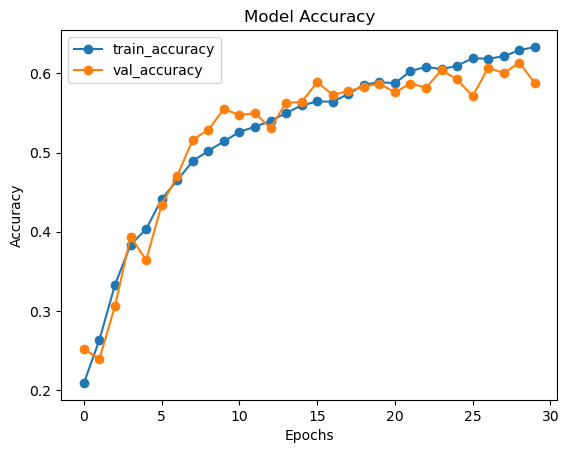

In [24]:
# Plotting model performance
plt.plot(history.history['accuracy'], label='train_accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Để đánh giá hiệu suất của một mô hình, đặc biệt là mô hình phân loại như mô hình sử dụng CNN để nhận diện cảm xúc trên khuôn mặt, có thể xem xét một số độ đo chính xác. Dưới đây là một số độ đo chính xác thường được sử dụng:

### Accuracy:

`Accuracy`= Number of Correct Predictions / Total Number of Prediction


### Precision:

`Precision`= True Positives / (True Positives + Fail Positives)

### Recall (Sensitivity):

`Recall`= True Positives / (False Negatives + True Positives)

### F1 Score:

`F1 Score`= 2 x ((Precision × Recall) / (Precision + Recall))

### Confusion Matrix:
Một bảng được sử dụng để mô tả hiệu suất của một mô hình phân loại, hiển thị số dương tính thật (True Positives), dương tính giả (False Positives), âm tính thật (True Negatives) và âm tính giả (False Negatives).

181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.56      0.43      0.49       769
           1       0.62      0.39      0.48        93
           2       0.39      0.43      0.41       823
           3       0.79      0.83      0.81      1507
           4       0.46      0.67      0.55       993
           5       0.56      0.33      0.42       955
           6       0.72      0.72      0.72       625

    accuracy                           0.59      5765
   macro avg       0.59      0.54      0.55      5765
weighted avg       0.60      0.59      0.58      5765



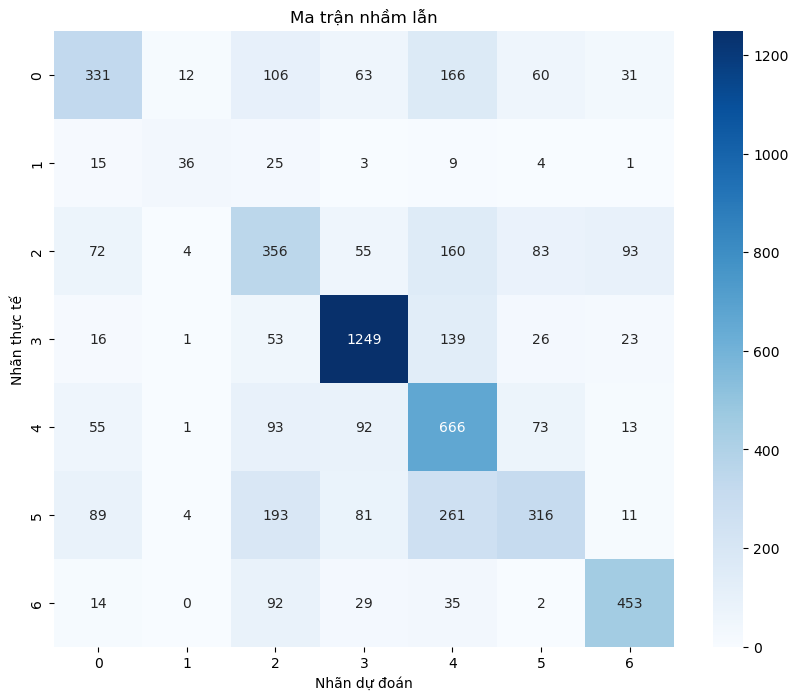

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, log_loss, accuracy_score
import seaborn as sns


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test  # Không cần dùng np.argmax vì y_test đã là nhãn số

# Báo cáo phân loại
print("Báo cáo phân loại:")
print(classification_report(y_true, y_pred_classes))

# Ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Ma trận nhầm lẫn')
plt.xlabel('Nhãn dự đoán')
plt.ylabel('Nhãn thực tế')
plt.show()